In [14]:
import pandas as pd
import scipy as sp
import numpy as np

from abtools import ABtest, ARPUModel

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [15]:
data = pd.read_csv('data.csv')

In [16]:
a = data.query('abgroup == "control"')['revenue']
b = data.query('abgroup == "test"')['revenue']

In [17]:
test = ABtest(ARPUModel, [a, b], 5000)

test.estimate()

ABtest for 2 groups


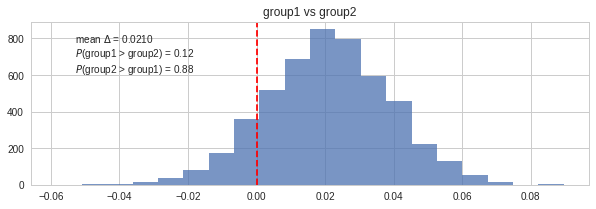

In [18]:
test.plot()

In [19]:
test.probabilities_df

,group1,group2,mean
group1,-,0.8766,1.11949601507
group2,0.1234,-,1.14051803111
mean,1.11949601507,1.14051803111,-
